In [ ]:
import numpy as np
import torch
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizer, BertModel
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import joblib
import os
import gradio as gr
import shap
from wordcloud import WordCloud

# Load cleaned datasets
train_df = pd.read_csv("clean/train_cleaned.csv")
val_df = pd.read_csv("clean/val_cleaned.csv")
test_df = pd.read_csv("clean/test_cleaned.csv")

# Extract text and labels
X_train, y_train = train_df["tweet"], train_df["label"]
X_val, y_val = val_df["tweet"], val_df["label"]
X_test = test_df["tweet"]  # No labels for test set

In [2]:
y_train

0       real
1       real
2       fake
3       real
4       real
        ... 
6415    fake
6416    fake
6417    fake
6418    fake
6419    real
Name: label, Length: 6420, dtype: object

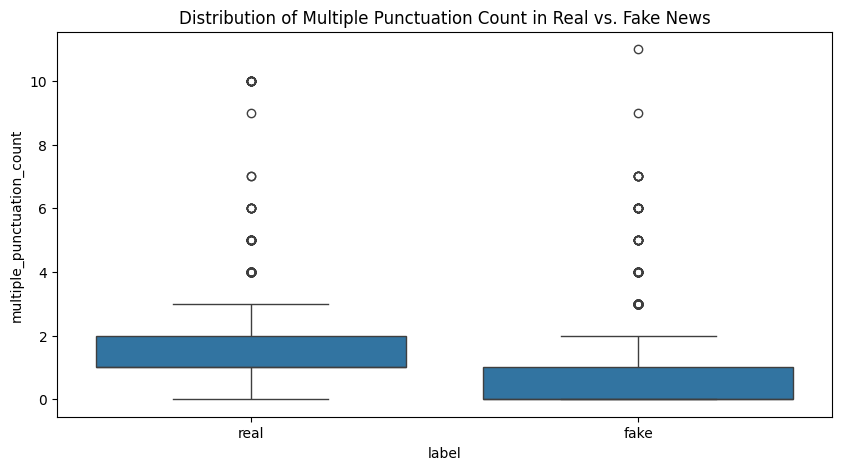

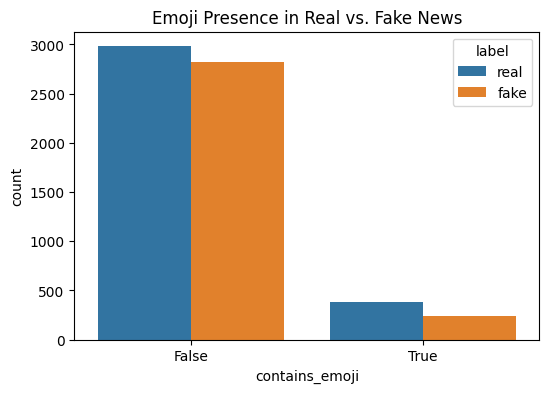

In [ ]:


# Plot distribution of multiple_punctuation_count for real vs fake news
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["label"], y=train_df["multiple_punctuation_count"])
plt.title("Distribution of Multiple Punctuation Count in Real vs. Fake News")
plt.show()

# Plot distribution of contains_emoji for real vs fake news
plt.figure(figsize=(6, 4))
sns.countplot(x="contains_emoji", hue="label", data=train_df)
plt.title("Emoji Presence in Real vs. Fake News")
plt.show()


In [4]:
# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [5]:
# Load BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # Set to evaluation mode to avoid gradient calculations

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
# Function to get BERT embeddings efficiently
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    data_loader = DataLoader(texts, batch_size=batch_size)
    
    with torch.no_grad():
        for batch in data_loader:
            tokens = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
            outputs = bert_model(**tokens)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())  # Take [CLS] token
    return np.vstack(embeddings)

X_train_bert = get_bert_embeddings(list(X_train))
X_val_bert = get_bert_embeddings(list(X_val))
X_test_bert = get_bert_embeddings(list(X_test))

In [7]:
y_train

0       real
1       real
2       fake
3       real
4       real
        ... 
6415    fake
6416    fake
6417    fake
6418    fake
6419    real
Name: label, Length: 6420, dtype: object

In [8]:
# Train Models
models = {
    "TF-IDF + XGBoost": xgb.XGBClassifier(
                            tree_method="hist", 
                            device="cuda",                     
                            max_bin=128,             
                            n_jobs=1,                
                            eval_metric="logloss",
                            early_stopping_rounds=10),
    "TF-IDF + Naive Bayes": MultinomialNB( 
                            fit_prior=True),
    "BERT + XGBoost": xgb.XGBClassifier(
                            tree_method="hist", 
                            device="cuda",                     
                            max_bin=128,             
                            n_jobs=1,
                            eval_metric="logloss",
                            early_stopping_rounds=10)
}

train_data = {
    "TF-IDF + XGBoost": (X_train_tfidf, X_val_tfidf, X_test_tfidf),
    "TF-IDF + Naive Bayes": (X_train_tfidf, X_val_tfidf, X_test_tfidf),
    "BERT + XGBoost": (X_train_bert, X_val_bert, X_test_bert),
}

In [9]:
label_mapping = {"fake": 0, "real": 1}
y_train = train_df["label"].map(label_mapping).astype(int)
y_val = val_df["label"].map(label_mapping).astype(int)

In [10]:
print(y_train.unique())  # Should print [0 1]
print(y_val.unique())    # Should print [0 1]


[1 0]
[0 1]


In [11]:
print(X_train.shape, X_test.shape)


(6420,) (2140,)


In [12]:
print("Unique values in y_train:", y_train.unique())
print("Unique values in y_val:", y_val.unique())

# Ensure numerical dtype
print("y_train dtype:", y_train.dtype)
print("y_val dtype:", y_val.dtype)


Unique values in y_train: [1 0]
Unique values in y_val: [0 1]
y_train dtype: int64
y_val dtype: int64



Tuning hyperparameters for TF-IDF + XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for TF-IDF + XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
Model saved successfully as saved_models/TF-IDF_+_XGBoost_best_model.joblib ✅
Results for TF-IDF + XGBoost on Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1020
           1       0.92      0.95      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



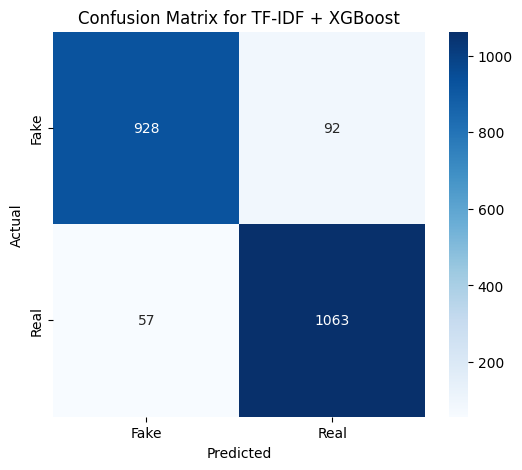

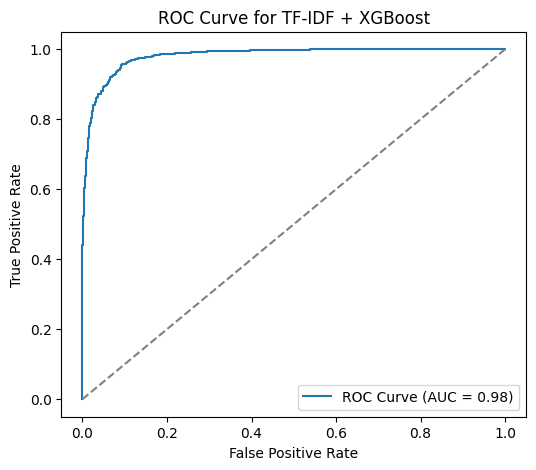


Tuning hyperparameters for BERT + XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for BERT + XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Model saved successfully as saved_models/BERT_+_XGBoost_best_model.joblib ✅
Results for BERT + XGBoost on Validation Set:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1020
           1       0.92      0.93      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



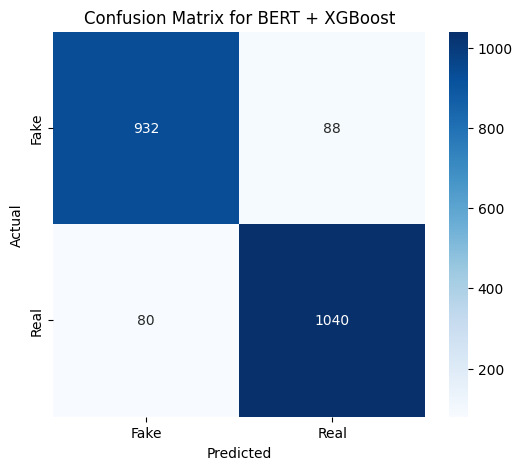

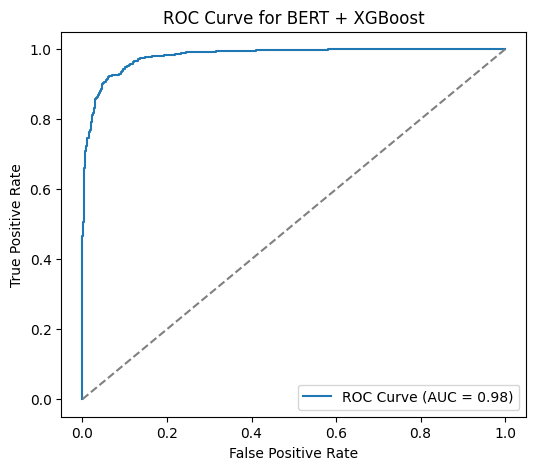


Tuning hyperparameters for TF-IDF + Naive Bayes...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for TF-IDF + Naive Bayes: {'alpha': 0.1}
Model saved successfully as saved_models/TF-IDF_+_Naive_Bayes_best_model.joblib ✅
Results for TF-IDF + Naive Bayes on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1020
           1       0.91      0.91      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



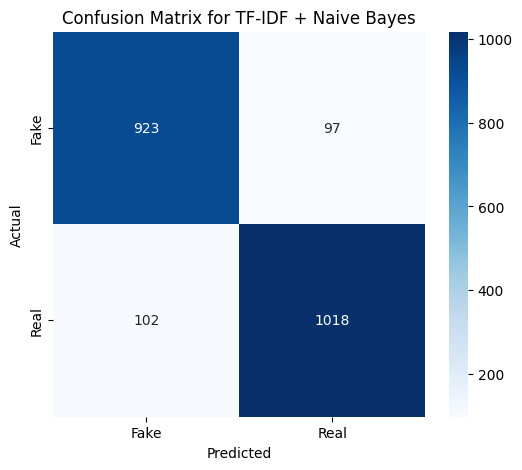

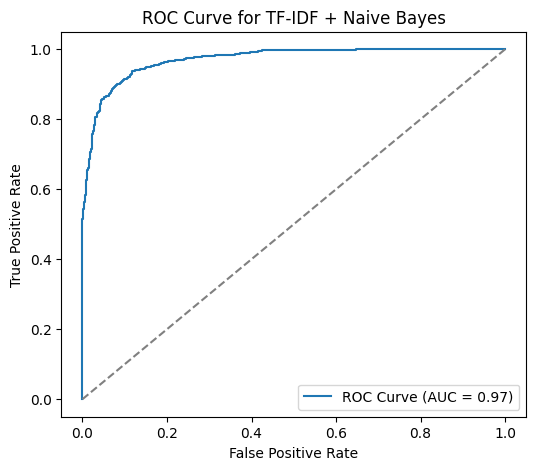

Predictions saved to label/test_predictions_labeled.csv


In [ ]:


# Ensure the directory exists for saving models
os.makedirs("saved_models", exist_ok=True)

# Define hyperparameters for tuning
param_grids = {
    "TF-IDF + XGBoost": {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.3],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "TF-IDF + Naive Bayes": {
        "alpha": [0.01, 0.1, 0.5, 1.0]  # Smoothing parameter
    },
    "BERT + XGBoost": {
        "n_estimators": [100, 300, 500],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.3],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}

# Initialize models
models = {
    "TF-IDF + XGBoost": XGBClassifier(eval_metric="logloss"),
    "BERT + XGBoost": XGBClassifier(eval_metric="logloss"),
    "TF-IDF + Naive Bayes": MultinomialNB()
}

# Mapping for numerical predictions
prediction_mapping = {1: "True", 0: "False"}

for name, model in models.items():
    print(f"\nTuning hyperparameters for {name}...")

    # Use GridSearchCV for tuning
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
    X_train_data, X_val_data, X_test_data = train_data[name]
    
    # Fit GridSearchCV
    grid_search.fit(X_train_data, y_train)
    best_model = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")

    # Train best model on full training set
    best_model.fit(X_train_data, y_train)
    
    # Save the trained model
    model_filename = f"saved_models/{name.replace(' ', '_')}_best_model.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Model saved successfully as {model_filename} ✅")

    # Predict on validation set
    y_pred_val = best_model.predict(X_val_data)
    y_pred_prob_val = best_model.predict_proba(X_val_data)[:, 1]

    print(f"Results for {name} on Validation Set:")
    print(classification_report(y_val, y_pred_val))

    # Predict on test set
    y_pred_test = best_model.predict(X_test_data)
    y_pred_prob_test = best_model.predict_proba(X_test_data)[:, 1]

    # Convert numerical predictions (0/1) to "True"/"False"
    test_df[f"{name}_prediction"] = [prediction_mapping[int(pred)] for pred in y_pred_test]
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

    # ROC-AUC Score & Curve
    auc_score = roc_auc_score(y_val, y_pred_prob_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob_val)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {name}")
    plt.legend()
    plt.show()

# Save predictions
test_df.to_csv("label/test_predictions_labeled.csv", index=False)
print("Predictions saved to label/test_predictions_labeled.csv")


In [ ]:
# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
# Load trained models
tfidf_xgb = joblib.load("saved_models/TF-IDF_+_XGBoost_best_model.joblib")
tfidf_nb = joblib.load("saved_models/TF-IDF_+_Naive_Bayes_best_model.joblib")
bert_xgb = joblib.load("saved_models/BERT_+_XGBoost_best_model.joblib")

# Load TF-IDF vectorizer
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Load BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def predict_fake_news(text):
    if not text or text.strip() == "":
        return "Error: No text provided.", "", ""

    try:
        # TF-IDF Transformation
        text_tfidf = tfidf_vectorizer.transform([text])

        # BERT Tokenization & Embedding Extraction
        text_bert = bert_tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")
        
        with torch.no_grad():
            bert_outputs = bert_model(**text_bert)  # Get embeddings
        text_bert_np = bert_outputs.last_hidden_state[:, 0, :].numpy()  # Extract CLS token embedding (1, 768)

        print("BERT Embedding Shape:", text_bert_np.shape)

        # TF-IDF + XGBoost
        prob_xgb = tfidf_xgb.predict_proba(text_tfidf)[:, 1][0]
        result_xgb = f"Fake ({prob_xgb:.2f})" if prob_xgb > 0.5 else f"Real ({prob_xgb:.2f})"

        # TF-IDF + Naive Bayes
        prob_nb = tfidf_nb.predict_proba(text_tfidf)[:, 1][0]
        result_nb = f"Fake ({prob_nb:.2f})" if prob_nb > 0.5 else f"Real ({prob_nb:.2f})"

        # BERT + XGBoost
        prob_bert_xgb = bert_xgb.predict_proba(text_bert_np)[:, 1][0]
        result_bert_xgb = f"Fake ({prob_bert_xgb:.2f})" if prob_bert_xgb > 0.5 else f"Real ({prob_bert_xgb:.2f})"

    except Exception as e:
        return f"Error: {str(e)}", "", ""

    return result_xgb, result_nb, result_bert_xgb


# Gradio UI
iface = gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=5, placeholder="Enter news text here..."),
    outputs=[
        gr.Textbox(label="TF-IDF + XGBoost"),
        gr.Textbox(label="TF-IDF + Naive Bayes"),
        gr.Textbox(label="BERT + XGBoost"),
    ],
    title="Fake Covid News Detector",
    description="Enter a news article to detect if it's Fake or Real using different ML models.",
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


BERT Embedding Shape: (1, 768)


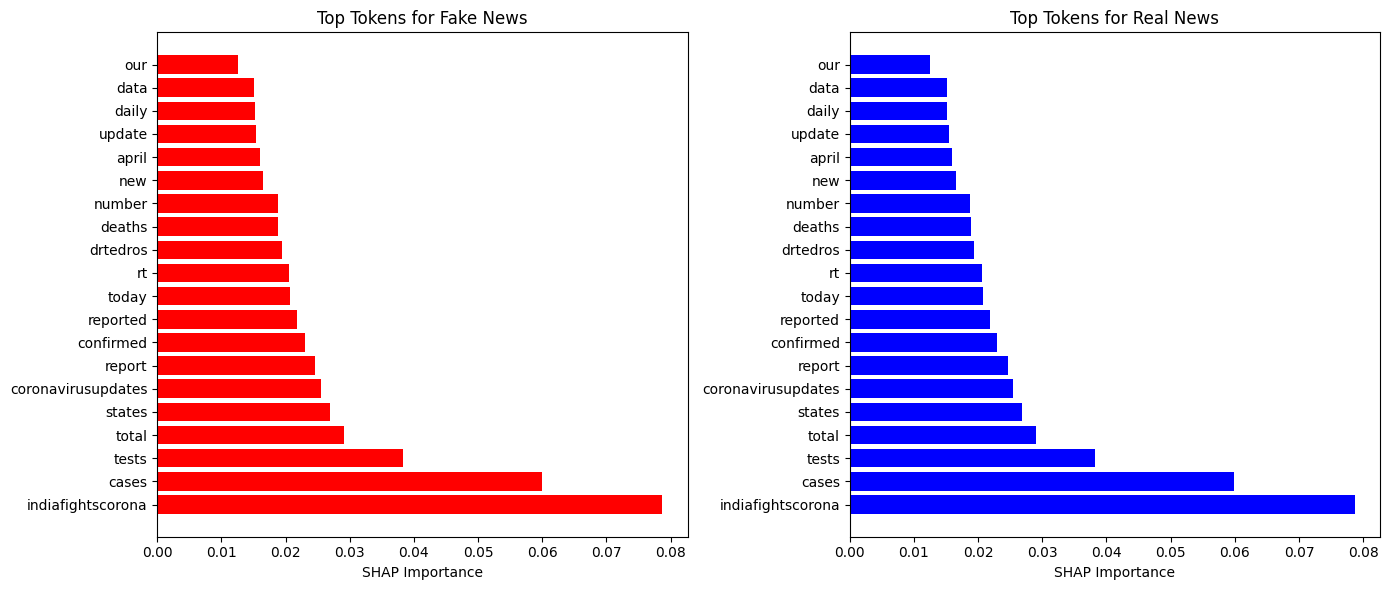

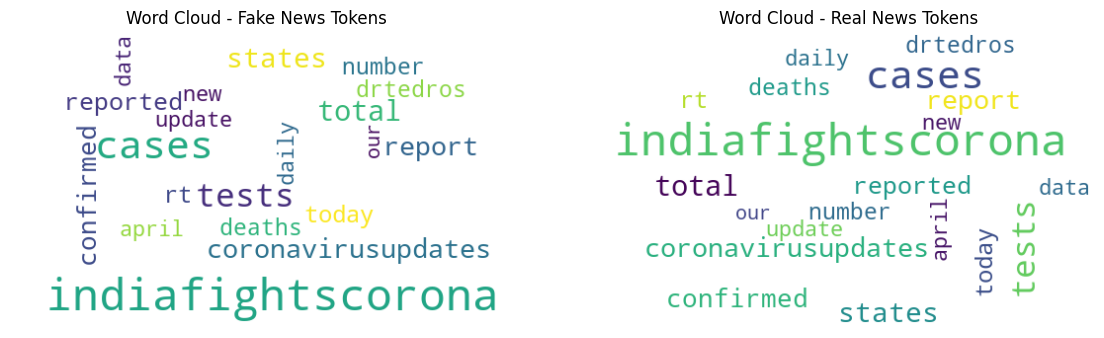

In [ ]:


tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

tfidf_xgb_model = joblib.load("saved_models/TF-IDF_+_XGBoost_best_model.joblib")

data = pd.read_csv("clean/train_cleaned.csv") 
X = tfidf_vectorizer.transform(data["tweet"]) 
y = data["label"]

explainer = shap.TreeExplainer(tfidf_xgb_model)

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

shap_values = explainer.shap_values(X)

# Check the structure of shap_values
if isinstance(shap_values, list) and len(shap_values) == 2:
    # Binary classification case
    shap_values_fake = np.array(shap_values[1]).mean(axis=0)  # Fake News Class
    shap_values_real = np.array(shap_values[0]).mean(axis=0)  # Real News Class
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    shap_values_fake = shap_values.mean(axis=0)
    shap_values_real = shap_values.mean(axis=0) 
else:
    raise ValueError("Unexpected SHAP values structure. Check model and SHAP library version.")

if shap_values_fake.shape[0] != len(feature_names):
    raise ValueError("Mismatch between SHAP values and feature names. Check model output.")

top_n = 20
fake_indices = np.argsort(shap_values_fake)[-top_n:]
real_indices = np.argsort(shap_values_real)[-top_n:]

fake_tokens = feature_names[fake_indices]
fake_importance = shap_values_fake[fake_indices]

real_tokens = feature_names[real_indices]
real_importance = shap_values_real[real_indices]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(fake_tokens, fake_importance, color='red')
ax[0].set_title("Top Tokens for Fake News")
ax[0].set_xlabel("SHAP Importance")
ax[0].invert_yaxis()

ax[1].barh(real_tokens, real_importance, color='blue')
ax[1].set_title("Top Tokens for Real News")
ax[1].set_xlabel("SHAP Importance")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

fake_wordcloud = WordCloud(width=500, height=300, background_color="white").generate_from_frequencies(dict(zip(fake_tokens, fake_importance)))
real_wordcloud = WordCloud(width=500, height=300, background_color="white").generate_from_frequencies(dict(zip(real_tokens, real_importance)))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(fake_wordcloud, interpolation="bilinear")
ax[0].axis("off")
ax[0].set_title("Word Cloud - Fake News Tokens")

ax[1].imshow(real_wordcloud, interpolation="bilinear")
ax[1].axis("off")
ax[1].set_title("Word Cloud - Real News Tokens")

plt.show()


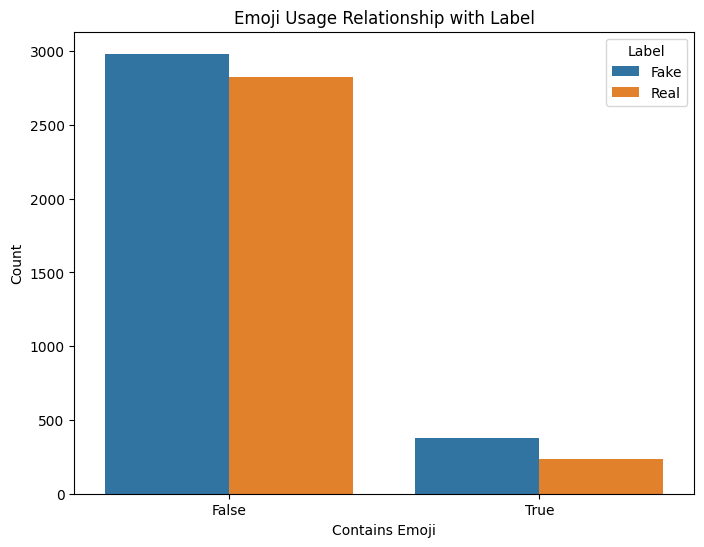

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x="contains_emoji", hue="label", data=train_df)
plt.title("Emoji Usage Relationship with Label")
plt.xlabel("Contains Emoji")
plt.ylabel("Count")
plt.legend(title="Label", labels=["Fake", "Real"])
plt.show()